In [1]:
import traceback
import os
import json
from cpitospin import analyze_cpi_structure, CPIToSPINConverter

# Choose the test
All the test available are in folder 'CPIs'

In [2]:
process_name = "test" #choice-task-init-reverse

## Load File 

In [3]:
cpi_file_path = f'../CPIs/{process_name}.cpi'

print(f"Loading CPI file: {cpi_file_path}")

try:
	with open(cpi_file_path, 'r') as f:
		cpi_dict = json.load(f)

	print("✓ CPI file loaded successfully!")
	print(f"Root region type: {cpi_dict['type']}")
	print(f"Root region ID: {cpi_dict['id']}")

	# Pretty print the CPI structure
	print("\nCPI Structure:")
	print("=" * 50)
	print(json.dumps(cpi_dict, indent=2))

except FileNotFoundError:
	print(f"❌ File not found: {cpi_file_path}")
	print("Available files in CPIs directory:")
	try:
		for f in os.listdir('../CPIs'):
			if f.endswith('.cpi'):
				print(f"  - {f}")
	except:
		print("  Could not list CPIs directory")
except Exception as e:
	print(f"❌ Error loading CPI file: {e}")
	traceback.print_exc()

Loading CPI file: ../CPIs/test.cpi
✓ CPI file loaded successfully!
Root region type: parallel
Root region ID: 0

CPI Structure:
{
  "type": "parallel",
  "id": 0,
  "first_split": {
    "type": "sequence",
    "id": 1,
    "head": {
      "type": "sequence",
      "id": 2,
      "head": {
        "type": "task",
        "id": 3,
        "duration": 8,
        "impacts": {
          "impact_1": 0.07782981756122748
        }
      },
      "tail": {
        "type": "task",
        "id": 4,
        "duration": 1,
        "impacts": {
          "impact_1": 0.028854375736701788
        }
      }
    },
    "tail": {
      "type": "parallel",
      "id": 5,
      "first_split": {
        "type": "task",
        "id": 6,
        "duration": 4,
        "impacts": {
          "impact_1": 0.08529702640727252
        }
      },
      "second_split": {
        "type": "sequence",
        "id": 7,
        "head": {
          "type": "task",
          "id": 8,
          "duration": 7,
          "imp

# FROM CPI TO SPIN

In [4]:
print("\nCPI Structure Analysis:")
print("=" * 50)
if 'cpi_dict' in locals():
	analyze_cpi_structure(cpi_dict)

print("Converting CPI to SPIN...")
print("=" * 50)

try:
	converter = CPIToSPINConverter()
	spin_model = converter.convert_cpi_to_spin(cpi_dict)

	print("✓ Conversion successful!")
	print("\nSPIN Model Summary:")
	print("-" * 30)
	spin_model.print_model_summary()

except Exception as e:
	print(f"❌ Conversion failed: {e}")
	traceback.print_exc()


CPI Structure Analysis:
parallel0
  first_split:
    sequence1
      head:
        sequence2
          head:
            task3
              duration: 8
              impacts: {'impact_1': 0.07782981756122748}
          tail:
            task4
              duration: 1
              impacts: {'impact_1': 0.028854375736701788}
      tail:
        parallel5
          first_split:
            task6
              duration: 4
              impacts: {'impact_1': 0.08529702640727252}
          second_split:
            sequence7
              head:
                task8
                  duration: 7
                  impacts: {'impact_1': 0.042224541208959764}
              tail:
                task9
                  duration: 7
                  impacts: {'impact_1': 0.05762294309228572}
  second_split:
    sequence10
      head:
        sequence11
          head:
            nature12
              probability: 0.20874507734446635
              true:
                task13
               


Creating visualizations...
✓ CPI visualization created
✓ SPIN visualization created

CPI Structure Visualization:


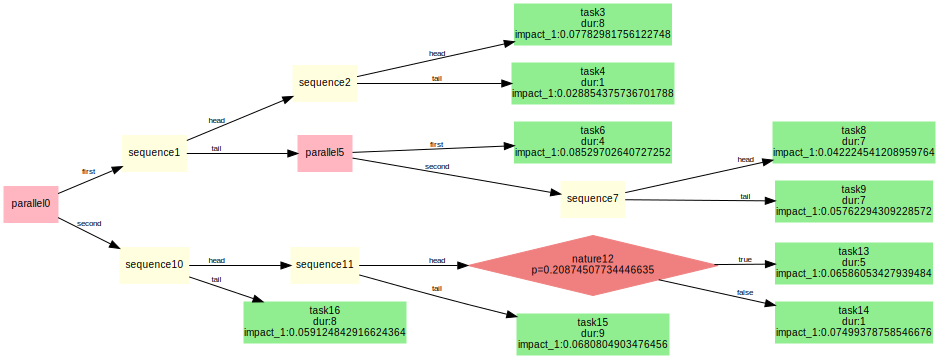


SPIN Model Visualization:


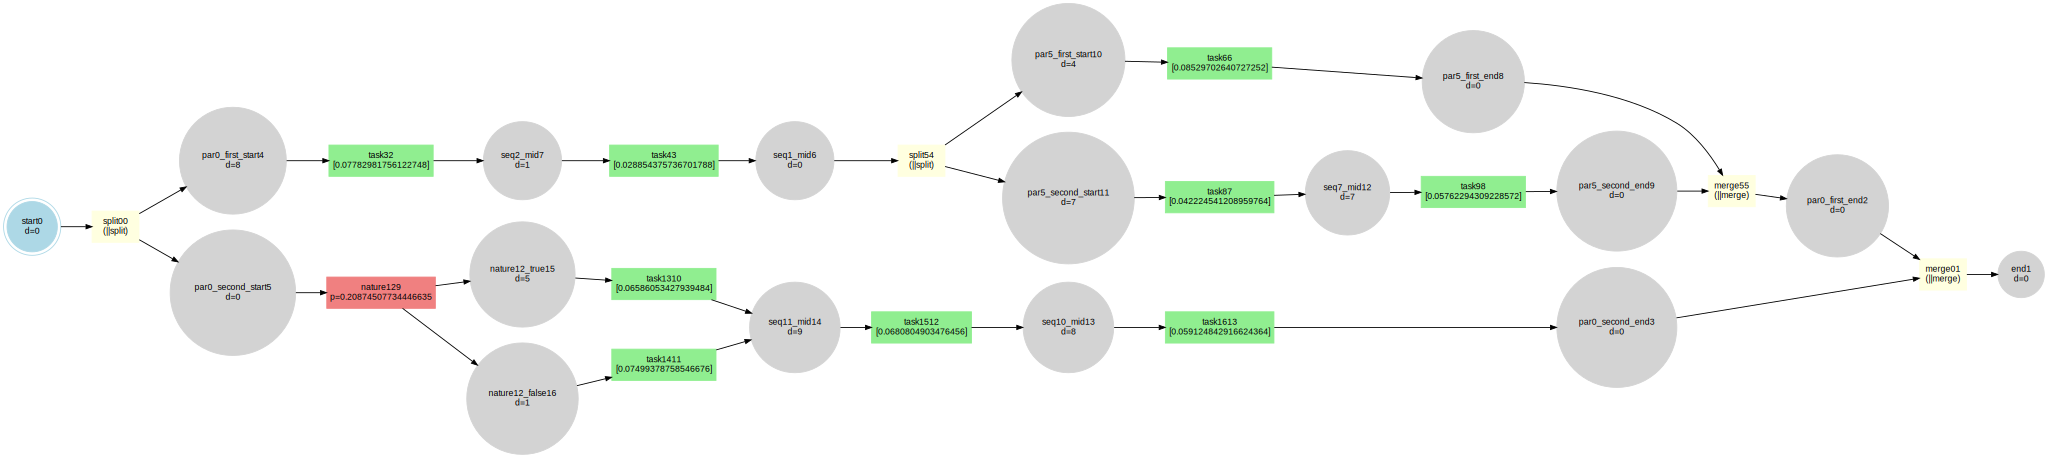

In [5]:
from cpitospin import create_cpi_visualization, create_spin_visualization

print("\nCreating visualizations...")
print("=" * 50)

try:
	# Create CPI visualization
	cpi_viz = create_cpi_visualization(cpi_dict, "CPI: Loop Example")
	print("✓ CPI visualization created")

	# Create SPIN visualization
	spin_viz = create_spin_visualization(spin_model, "SPIN: Loop Example")
	print("✓ SPIN visualization created")

	# Display visualizations (if in Jupyter)
	try:
		print("\nCPI Structure Visualization:")
		display(cpi_viz)

		print("\nSPIN Model Visualization:")
		display(spin_viz)
	except NameError:
		# Not in Jupyter, save to files instead
		print("Saving visualizations to files...")

		# Save CPI visualization
		cpi_output = process_name + '_cpi'
		cpi_viz.render(cpi_output, cleanup=True)
		print(f"CPI visualization saved to: {cpi_output}.png")

		# Save SPIN visualization
		spin_output = process_name + '_spin'
		spin_viz.render(spin_output, cleanup=True)
		print(f"SPIN visualization saved to: {spin_output}.png")

except Exception as e:
	print(f"❌ Visualization failed: {e}")
	traceback.print_exc()


# FROM SPIN TO PRISM

In [6]:
print("\nGenerating PRISM model...")
print("=" * 50)

try:
	prism_model = spin_model.generate_prism_model()

	print("✓ PRISM model generated successfully!")

	# Show model statistics
	lines = prism_model.split('\n')
	words = prism_model.split()

	print(f"Model statistics:")
	print(f"  Lines: {len(lines)}")
	print(f"  Words: {len(words)}")
	print(f"  Characters: {len(prism_model)}")

	# Show first 20 lines
	print(f"\nFirst 20 lines of PRISM model:")
	print("-" * 40)
	for i, line in enumerate(lines[:20]):
		print(f"{i + 1:2d}: {line}")

	if len(lines) > 20:
		print(f"... ({len(lines) - 20} more lines)")

except Exception as e:
	print(f"❌ PRISM generation failed: {e}")
	traceback.print_exc()

print("\nSaving PRISM model...")
print("=" * 50)

try:
	output_file =  "../models/" + process_name + '.nm'
	with open(output_file, 'w') as f:
		f.write(prism_model)

	print(f"✓ PRISM model saved to: {output_file}")

	# Verify file was created
	if os.path.exists(output_file):
		file_size = os.path.getsize(output_file)
		print(f"File size: {file_size} bytes")
	else:
		print("❌ Warning: File was not created")

except Exception as e:
	print(f"❌ Save failed: {e}")
	traceback.print_exc()


Generating PRISM model...
✓ PRISM model generated successfully!
Model statistics:
  Lines: 599
  Words: 4333
  Characters: 50885

First 20 lines of PRISM model:
----------------------------------------
 1: // Global variables for places
 2: global STAGE : [0..5] init 0;
 3: 
 4: // Place value variables
 5: global end1_value : [-1..0] init -1;
 6: global nature12_false16_value : [-1..1] init -1;
 7: global nature12_true15_value : [-1..5] init -1;
 8: global par0_first_end2_value : [-1..0] init -1;
 9: global par0_first_start4_value : [-1..8] init -1;
10: global par0_second_end3_value : [-1..0] init -1;
11: global par0_second_start5_value : [-1..0] init -1;
12: global par5_first_end8_value : [-1..0] init -1;
13: global par5_first_start10_value : [-1..4] init -1;
14: global par5_second_end9_value : [-1..0] init -1;
15: global par5_second_start11_value : [-1..7] init -1;
16: global seq10_mid13_value : [-1..8] init -1;
17: global seq11_mid14_value : [-1..9] init -1;
18: global seq1_mid6_v

## RUN PRISM ANALYSIS

In [7]:
!prism

PRISM
=====

Version: 4.8.1
Date: Tue Jun 10 19:07:07 UTC 2025
Hostname: c444078b476d
Memory limits: cudd=1g, java(heap)=1g
Command line: prism
Usage: prism [options] <model-file> [<properties-file>] [more-options]

For more information, type: prism -help


In [8]:
from run_prism import run_prism_analysis
run_prism_analysis(process_name)

Running PRISM command: prism /app/models/test.nm -exporttransdotstates /app/results/test/test.dot -exportstates /app/results/test/test_states.csv -exporttrans /app/results/test/test_trans.tra -verbose
Analysis complete. Results saved to ../results/test/test.info


{'timestamp': '2025-06-10T19:08:03.482991',
 'modules': ['manager',
  'merge01',
  'merge55',
  'nature129',
  'split00',
  'split54',
  'task1310',
  'task1411',
  'task1512',
  'task1613',
  'task32',
  'task43',
  'task66',
  'task87',
  'task98'],
 'variables': ['STAGE',
  'end1_value',
  'nature12_false16_value',
  'nature12_true15_value',
  'par0_first_end2_value',
  'par0_first_start4_value',
  'par0_second_end3_value',
  'par0_second_start5_value',
  'par5_first_end8_value',
  'par5_first_start10_value',
  'par5_second_end9_value',
  'par5_second_start11_value',
  'seq10_mid13_value',
  'seq11_mid14_value',
  'seq1_mid6_value',
  'seq2_mid7_value',
  'seq7_mid12_value',
  'start0_value',
  'end1_updated',
  'nature12_false16_updated',
  'nature12_true15_updated',
  'par0_first_end2_updated',
  'par0_first_start4_updated',
  'par0_second_end3_updated',
  'par0_second_start5_updated',
  'par5_first_end8_updated',
  'par5_first_start10_updated',
  'par5_second_end9_updated',
  'pa

In [9]:
from graphviz import Source
with open(f"../results/{process_name}/{process_name}.dot", 'r', encoding='utf-8') as f: 
    dot_content = f.read() 
    graph = Source(dot_content) # Esporta in SVG graph.render(filename=output_path, format='svg', cleanup=True)
    graph.render(filename=f"../results/{process_name}/{process_name}", format='svg', cleanup=True)

# FROM PRISM TO MDP

Since PRISM models are based on an extended form of MDPs, we now provide the compact version of the MDP generated by PRISM, which corresponds to the equivalent SPIN model. This enhances clarity and facilitates easier comparison between the two representations.

   0  1     2  3     4
0  0  0    11  1  None
1  1  0  1996  1  None
2  2  0     1  1  None
3  3  0     2  1  None
4  4  0     3  1  None
(2334, 5)
has prob True
268 [324, 344]
digraph LTS {
node [label="", shape="box"];
14 [label="14\n(start0=0)"];
14 -> 268;
95 [label="95\n(par5_first_start10=1, par5_second_start11=1, seq10_mid13=0)"];
95 -> 253;
253 [label="253\n(par0_second_end3=0, par5_first_end8=0, par5_second_end9=0)"];
253 -> 309;
268 [label="268\n(par0_first_start4=0, par0_second_start5=0)"];
268 -> 324;
268 -> 344;
269 [label="269\n(par0_first_start4=1, seq11_mid14=0)"];
269 -> 95;
309 [label="309\n(par0_first_end2=0, par0_second_end3=0)"];
309 -> 374;
324 [label="324\n(nature12_true15=0, par0_first_start4=0)"];
324 -> 325;
325 [label="325\n(nature12_true15=1, par0_first_start4=1)"];
325 -> 253;
344 [label="344\n(nature12_false16=0, par0_first_start4=0)"];
344 -> 359;
359 [label="359\n(nature12_false16=1, par0_first_start4=1)"];
359 -> 269;
374 [label="374\n(end1=0)"];
}


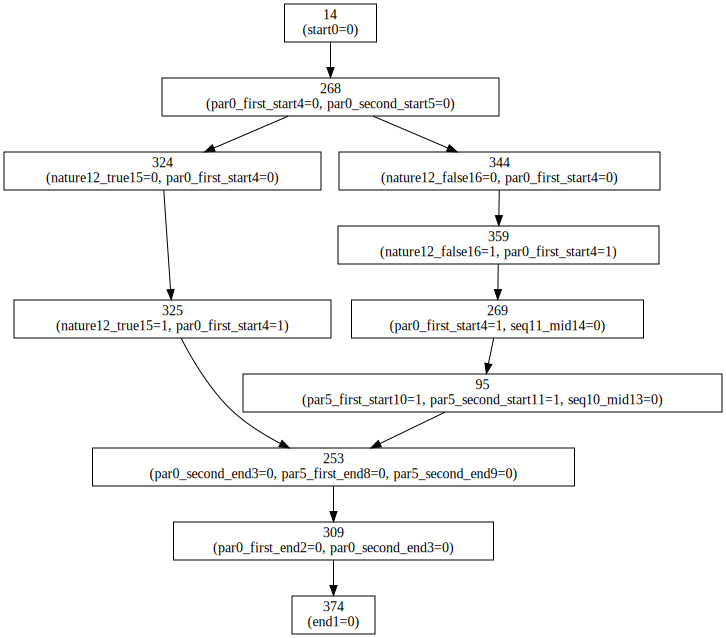

In [13]:
from graphviz import Source
import pandas as pd
import re
import networkx as nx
from collections import defaultdict
def create_states_mdp(process_name: str = 'test'):
    # Load DOT content
    with open(f"../results/{process_name}/{process_name}.dot", 'r', encoding='utf-8') as f:
        dot_content = f.read()

    # Load and clean the DataFrame
    df = pd.read_csv(f"../results/{process_name}/{process_name}_states.csv")
    df['STAGE'] = df['(STAGE'].apply(lambda x: x.split(':')[-1].split('(')[-1] if isinstance(x, str) else x)
    df.drop(columns=['(STAGE'], inplace=True)

    paren_cols = [col for col in df.columns if col.endswith(')')]
    for col in paren_cols:
        df[col.replace(')', '')] = df[col].apply(lambda x: x[-2] if isinstance(x, str) and len(x) >= 2 else x)
        df.drop(columns=[col], inplace=True)

    df = df.apply(pd.to_numeric)

    # Select relevant columns
    update_cols = [col for col in df.columns if col.endswith('_update')]
    state_cols = [col for col in df.columns if col.endswith('_state')]
    value_cols = [col for col in df.columns if col.endswith('_value')]

    # Identify new states
    stage_mask = df['STAGE'].isin([0])
    update_mask = (df[update_cols] == 0).all(axis=1)
    state_mask = (df[state_cols] == 0).all(axis=1)
    new_states_df = df[stage_mask & update_mask & state_mask]
    new_state_ids = new_states_df.index.astype(str).tolist()
    # Build graph from DOT
    edge_pattern = re.compile(r'(\d+)\s*->\s*(\d+)')
    edges = edge_pattern.findall(dot_content)
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Remove nodes whose any *_value ends in digit > 1
    nodes_to_remove = []
    for node_id in new_states_df.index:
        row = new_states_df.loc[node_id]
        for col in value_cols:
            val = row[col]
            if val >= 0 and int(val) > 1:
                nodes_to_remove.append(str(node_id))
                break  # No need to check other columns

    # Rewire graph to preserve structure
    # for node in nodes_to_remove:
    #     if node in G.nodes:
    #         preds = list(G.predecessors(node))
    #         succs = list(G.successors(node))
    #         G.remove_node(node)
    #         for u in preds:
    #             for v in succs:
    #                 if u != v:
    #                     G.add_edge(u, v)

    # Compress new state nodes if connected directly
    # compressed_edges = []
    remaining_new_state_ids = [int(nid) for nid in new_state_ids if nid not in nodes_to_remove]
    new_state_set = set(remaining_new_state_ids)
    # for src in remaining_new_state_ids:
    #     for tgt in remaining_new_state_ids:
    #         if src != tgt and src in G and tgt in G and nx.has_path(G, src, tgt):
    #             path = nx.shortest_path(G, src, tgt)
    #             intermediates = set(path[1:-1])
    #             if not intermediates & new_state_set:
    #                 compressed_edges.append((src, tgt))

    # Generate DOT
    lines = ['digraph LTS {', 'node [label="", shape="box"];']

    def format_label(row):
        parts = [
            f"{col.replace('_value', '')}={int(row[col])}"
            for col in value_cols if row[col] >= 0
        ]
        return f'{row.name} [label="{row.name}\\n(' + ", ".join(parts) + ')"];'

    
    # add -> transitions 

    trans = pd.read_csv(f"../results/{process_name}/{process_name}_trans.tra", skiprows=1, header= None)[0].str.split(expand=True)
    print(trans.head())
    print(trans.shape)
    # Check if 'prob' column exists (based on column count)
    has_prob = trans.shape[1] >= 5
    
    # Extract relevant columns
    if has_prob:
        source_dest = trans[[0, 2, 3]]
        source_dest.columns = ['source', 'destination', 'prob']
    else:
        source_dest = trans[[0, 2]]
        source_dest.columns = ['source', 'destination']
    # Create dictionary: {source: [(destination, prob)]} or {source: [(destination,)]}
    trans_dict = defaultdict(list)
    print('has prob' , has_prob)
    for _, row in source_dest.iterrows():
        source = int(row['source'])
        destination = int(row['destination'])
        prob = float(row['prob']) if has_prob else 1.0  # Default prob to 1.0 if missing
        trans_dict[source].append((destination, prob))
    
    # Optional: convert to regular dict
    trans_dict = dict(trans_dict)
    def find_next_state(src:int, trans_dict:dict, possible_targets):  
        res = []
        for i in range(len(trans_dict[src])):
            if src == trans_dict[src][i][0]:
                return [] # it's final 
            if trans_dict[src][i][0] in possible_targets:
                res.append(trans_dict[src][i][0]) # questo significa che src e target sono collegati direttamente             
        if len(res) > 0:
            return res
        for i in range(len(trans_dict[src])):
            res.extend(find_next_state( trans_dict[src][i][0], trans_dict, possible_targets)) # continua a cercare ma la destinazione è diventata source
        return res
    for idx, row in new_states_df.iterrows():
        if str(idx) not in nodes_to_remove:
            lab = format_label(row)
            lines.append(lab) 
            targets = find_next_state(idx, trans_dict, new_state_set)
            if len(targets) > 1:
                print(idx, targets)
            for t in targets:
                lines.append(f'{idx} -> {t};')
                
    
    lines.append('}')
    compressed_dot = "\n".join(lines)
    print(compressed_dot)
    Source(compressed_dot).render(filename=f"../results/{process_name}/{process_name}_cleaned", format='svg', cleanup=True)
    return Source(compressed_dot)

create_states_mdp(process_name )# = 'parallel'

In [11]:
pd.read_csv(f"../results/{process_name}/{process_name}_states.csv")

,(STAGE,end1_value,nature12_false16_value,nature12_true15_value,par0_first_end2_value,par0_first_start4_value,par0_second_end3_value,par0_second_start5_value,par5_first_end8_value,par5_first_start10_value,...,split54_state,task1310_state,task1411_state,task1512_state,task1613_state,task32_state,task43_state,task66_state,task87_state,task98_state)
0,0:(0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0)
1,1:(0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1)
2,2:(0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,0)
3,3:(0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,0,0)
4,4:(0,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,0,0,0)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,2328:(5,-1,-1,-1,0,-1,0,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0)
2329,2329:(5,-1,-1,0,-1,0,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0)
2330,2330:(5,-1,0,-1,-1,0,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0)
2331,2331:(5,0,-1,-1,-1,-1,-1,-1,-1,-1,...,0,0,0,0,0,0,0,0,0,0)


In [12]:
pd.read_csv(f"../results/{process_name}/{process_name}_trans.tra", skiprows=1, header = None)

,0
0,0 0 11 1
1,1 0 1996 1
2,2 0 1 1
3,3 0 2 1
4,4 0 3 1
...,...
2329,2328 0 309 1
2330,2329 0 324 1
2331,2330 0 344 1
2332,2331 0 2332 1
